In [5]:
import os,time,pickle
import numpy as np 
import astropy.table as aTable
import astropy.io.fits as fits
from torch import nn
from torch import optim

import urllib.request
import requests,json
import matplotlib.pyplot as plt
from accelerate import Accelerator
from torchinterp1d import Interp1d

from util import *
from emission_lines import emissionlines
from model import *


dat_dir = '/scratch/gpfs/yanliang/'

lmbda_min = 2371;lmbda_max = 10402;bins = 7000
wave_rest = torch.linspace(lmbda_min, lmbda_max, 
                           bins, dtype=torch.float32)
        
def load_model(fileroot,n_latent=10):
    if not torch.cuda.is_available():
        device = torch.device('cpu')
    else:
        device = None
    
    path = f'{fileroot}.pt'
    print("path:",path)
    model = torch.load(path, map_location=device)
    if type(model)==list or type(model)==tuple:
        [m.eval() for m in model]
    elif type(model)==dict:
        mdict = model
        print("states:",mdict.keys())

        models = mdict["model"]
        instruments = mdict["instrument"]
        model = []
        if "n_latent" in mdict:n_latent=mdict["n_latent"]
        for m in models:
            loadm = SpectrumAutoencoder(wave_rest,n_latent=n_latent)
            loadm.load_state_dict(m)
            loadm.eval()
            model.append(loadm)
            
        for ins in instruments:
            empty=Instrument(wave_obs=None, calibration=None)
            model.append(empty)
        
    else: model.eval()
    path = f'{fileroot}.losses.npy'
    loss = np.load(path)
    print (f"model {fileroot}: iterations {len(loss)}, final loss: {loss[-1]}")
    return model, loss

def sdss_name(plate, mjd, fiberid):
    flocal = os.path.join(dat_dir, 'sdss-spectra/spec-%s-%i-%s.fits' % (str(plate).zfill(4), mjd, str(fiberid).zfill(4)))
    return flocal

def download_spectra(plate, mjd, fiberid,override=False): 
    url = 'https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/%s/spec-%s-%i-%s.fits' % (str(plate).zfill(4), str(plate).zfill(4), mjd, str(fiberid).zfill(4))    
    flocal = os.path.join(dat_dir, os.path.basename(url))
    if override or not os.path.isfile(flocal):
        #print(plate, mjd, fiberid)
        urllib.request.urlretrieve(url, flocal)
    return None

def read_sdss_spectra(key):
    
    plate, mjd, fiberid = [int(ii) for ii in key.split("-")]
    
    '''read sdss spectra downloaded from https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/
    '''
    flocal = sdss_name(plate, mjd, fiberid)
    
    print("flocal:",flocal)
    if not os.path.isfile(flocal): 
        raise ValueError
    hdulist = fits.open(flocal)
    
    header = hdulist[0].header
    meta = hdulist[2].data
    data = hdulist[1].data

    # metadata from header
    z = meta['Z']
    zerr = meta['Z_ERR']

    # read data
    logw = data['loglam']
    spec = data['flux']
    ivar = data['ivar'] 
    mask = data['and_mask'].astype(bool)
    ivar[mask] = 0.

    return logw, spec, ivar, mask, z, zerr

def add_emission(ax,z=0, ymax=0, xlim=(3000,7000),alpha=0.3,
                 color="grey",ytext=0.5,zorder=5):
    
    lines = [i for i in emissionlines]
    
    if not ymax:ymax = ax.get_ylim()[1]
    
    ymin = -10
    shifted = np.array(lines)*(1+z)
    ax.vlines(x=shifted,ymin=ymin,ymax=1.1*ymax,
              color=color,lw=1,alpha=alpha,zorder=zorder)
    
    for line in emissionlines:
        
        name = emissionlines[line]
        shifted = np.array(line)*(1+z)
        
        if shifted<xlim[0] or shifted>xlim[1]:continue
            
        ax.text(shifted,ytext,name,fontsize=20,
                color=color,rotation=90,zorder=zorder)
                
    return

def solve_z(self, x, w, z_guess, n_epoch=10, lr=1e-3):
    inspect_model.eval()
    accelerator = Accelerator()
    z = torch.tensor(z_guess.clone().detach(), requires_grad=True)
    #print(z)
    optimizer = optim.Adam([z,], lr=lr)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, total_steps=n_epoch)
    self, optimizer, z, x, w = accelerator.prepare(self, optimizer, z, x, w)
    
    for epoch in range(n_epoch):
        optimizer.zero_grad()
        s, spectrum_restframe, spectrum_observed = self._forward(x, wave=wave_obs,z0=z)
        loss = self._loss(x, w, spectrum_observed)
        accelerator.backward(loss)
        optimizer.step()        
        scheduler.step()
    print("loss:",loss)
    return z

def plot_norm(norms):

    print("norms",norms.shape)

    fig,ax = plt.subplots(figsize=(5,3),dpi=150)

    bins = np.logspace(-1,3,10)
    ax.hist(norms,bins=bins,color='k',
            histtype='step',log=True)
    ax.set_xscale("log")
    ax.set_xlabel("norm")
    ax.set_ylabel("N")
    plt.tight_layout()
    plt.savefig("[norm]test-hist.png",dpi=150)
    return

def boss_sdss_id():
    save_targets = "/home/yanliang/spectrum-encoder/joint_headers.pkl"


    f = open(save_targets,"rb")
    targets = pickle.load(f)
    f.close()


    id_names = ['PLATE','MJD','FIBERID']
    sdss_names = ["%s_%s"%(k,"SDSS") for k in id_names]
    boss_names = ["%s_%s"%(k,"BOSS") for k in id_names]

    sdss_id = []
    boss_id = []

    for j in range(len(targets)):
        plate, mjd, fiber = [targets[k][j] for k in boss_names]
        boss_id.append("%d-%d-%d"%(plate, mjd, fiber))

        plate, mjd, fiber = [targets[k][j] for k in sdss_names]
        sdss_id.append("%d-%d-%d"%(plate, mjd, fiber))
        
    return sdss_id,boss_id

def polynomial(y, Npoly = 3):
    D = y.shape[1]
    if torch.cuda.is_available():device = "cuda"
    else: device = torch.device('cpu')
    xprime = torch.linspace(0,1,D,device=device) # uniform in 0~1
    power = torch.arange(Npoly,-1,step=-1,device=device,dtype=torch.int32)
    A = xprime.unsqueeze(-1).pow(power)
    param = A.pinverse() @ y.T
    yfit = A@param 
    return yfit.T, param.T

def boss2sdss(boss_list):
    sdss_list = []
    for boss in boss_list:
        index = BOSS_id.index(boss)
        sdss_list.append(SDSS_id[index])
    return np.array(sdss_list)

def sdss2boss(sdss_list):
    boss_list = []
    for name in sdss_list:
        index = SDSS_id.index(name)
        boss_list.append(BOSS_id[index])
    return np.array(boss_list)
        
def plot_loss(loss, ax=None,xlim=None,ylim=None,fs=15):
    latest = loss[:2,-1]
    ep = range(len(loss[0]))
    
    if not ax:fig,ax=plt.subplots(dpi=200)
    labels = ["Train SDSS","Valid SDSS","Train BOSS","Valid BOSS"]
    colors = ['k','r','b','orange']
    
    minimum = np.min(loss[:2])
    
    final_ep = loss[:,-1]
    for i in range(len(loss)):
        if sum(loss[i])==0:continue
        ax.semilogy(ep,loss[i],label="%s(loss=%.2f)"%(labels[i],final_ep[i]),
                                                      color=colors[i])
        
    #ax.axhline(0.5,ls="--",color="b",label="loss = 0.5")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(loc="best",fontsize=fs)
    
    if min(latest)==minimum:
        print("%.2f is the minimum!"%minimum)
    return

def find_intersection(ids_sdss,ids_boss):
    joint_ids = []
    for ii in ids_boss:
        if not ii in BOSS_id: continue   
        sdss_key = boss2sdss([ii])[0]
        if not sdss_key in ids_sdss:continue
        joint_ids.append(sdss_key)
    print("intersection:",len(joint_ids))
    return joint_ids

def concatenate(samples,dim=10):
    ls = [len(s) for s in samples]
    print(ls)
    keys = []
    
    s_matrix = torch.zeros((sum(ls),dim))
    begin = 0
    for i,sample in enumerate(samples):
        end = begin+ls[i]
        key = np.arange(begin,end)
        s_matrix[key]=sample
        keys.append(key)
        begin=end
    return s_matrix,keys


def plot_panel(ax, wh_model,wh_joint,ymax=200, wid = 0.01,lw=1):
    
    wh_sdss = wh_joint[0][wh_model]
    
    ax.plot(wave_sdss, spec_sdss[wh_sdss],'-', c=colors[0],
            drawstyle='steps-mid',lw=lw,ms=5,
            label=labels[0])

    ax.plot(wave_sdss,sdss_model[wh_model],"-",c=colors[2], drawstyle='steps-mid',
            lw=lw,ms=5,label=labels[2],zorder=10)
    
    if wh_joint[1]==[]:return
    wh_boss = wh_joint[1][wh_model]
    
    ax.plot(wave_boss, spec_boss[wh_boss],'-',c=colors[1], 
            drawstyle='steps-mid',lw=lw,ms=5,
            label=labels[1])
    ax.plot(wave_boss,boss_model[wh_model],"-",c=colors[3],drawstyle='steps-mid',
            lw=lw,ms=5,label=labels[3])
    
    w = weight_boss[wh_model].detach().numpy()
    x = wave_boss.detach().numpy()
    
    #msk = (x>5280)*(x<5300)
    #print("x:",x[msk],"w:",w[msk])
    null_y = np.zeros_like(x)
    
    _,_,_, im = ax.hist2d(x,null_y, weights=w, cmap='Greys_r',
                          alpha=1,bins=[2000,[0,10*ymax]])
    #cb = fig.colorbar(im, ax = ax)#, ticks=[0,50,100])
    #cb.set_label("BOSS weight")
    return


def plot_sample(wh_model,wh_joint,wid = 0.01,lw=1):
    which = "SDSS"
    
    wh_sdss = wh_joint[0][wh_model]
    ymax = max(spec_sdss[wh_sdss])
    
    z = z_sdss[wh_sdss].item()
    ak = wave_sdss[(sdss_model[wh_model]==max(sdss_model[wh_model]))]

    fig,axs = plt.subplots(figsize=(8,10),nrows=2,dpi=150)
    ax = axs[0]

    plot_panel(ax,wh_model,wh_joint)
    add_emission(ax, z, ymax)
    
    print("z sdss:",z)
    ax.set_xlim(min(wave_boss),max(wave_boss))
    ax.set_ylim(-1e-2*ymax,1.1*ymax)
    ax.set_xlabel("observed $\lambda (\AA)$")
    ax.legend(loc='best',title="($z = %.3f$)ID: %s"%(z,sdss_key[wh_model]))
    
    ax = axs[1]

    plot_panel(ax,wh_model,wh_joint)
    add_emission(ax, z, ymax)
    
    #ak = 4100
    ax.set_xlim((1-wid)*ak,(1+wid)*ak)
    ax.set_ylim(0,1.1*ymax)
    ax.set_xlabel("observed $\lambda (\AA)$")
    ax.legend(loc='best')
    return
    ax = axs[2]
    
    plot_panel(ax,wh_model,wh_joint)
    add_emission(ax, z, ymax)
    ak = wave_sdss[-1]

    ak = 4100
    
    wid*=5
    ax.set_xlim((1-wid)*ak,(1+wid)*ak)

    ax.set_ylim(0,1.1*ymax)
    ax.set_xlabel("observed $\lambda (\AA)$")
    ax.legend(loc='best')
    return

def draw_line(marks, ax, lw=1):
    mark_sdss,mark_boss = marks
    for i in range(mark_sdss.shape[1]):
        #if not i in max_ind:continue
        locx = np.vstack((mark_sdss[:,i],mark_boss[:,i])).T
        ax.plot(locx[0],locx[1],'k-',lw=lw,alpha=1)
    return

def plot_embedding(embedded,color_code,name,zoom=False,cmap=None, c_range=[0,0.5],
                   cbar_label="$z$",comment=[],color=None,markers=None,ax=None,mute=False):
    labels = ['SDSS','BOSS']
    if not markers:markers = ["o",'^']
    
    alpha = 1;ms = 50;lw = 1
    
    embedding_sdss,embedding_boss = embedded[0]
    
    if color_code==[]:
        color_code = ['salmon','skyblue']
    img = ax.scatter(embedding_sdss[0],embedding_sdss[1], edgecolors='salmon',
                     s=ms, vmin=c_range[0],vmax=c_range[1],c=color_code[0],label=labels[0],
                     alpha=alpha,cmap=cmap)
    
    ax.scatter(embedding_boss[0],embedding_boss[1],s=ms,vmin=c_range[0],vmax=c_range[1], 
               edgecolors='b',c=color_code[1],alpha=alpha,cmap=cmap,label=labels[1])

    cbar = plt.colorbar(img)
    cbar.set_label(cbar_label)
    
    nbatch = len(embedded)-1
    
    if len(comment)==0:comment=[{}]*nbatch
    if not color:color = [['salmon','skyblue']]*nbatch
    
    for k in range(nbatch):
        batch = embedded[1+k]
        
        if len(batch)==2:draw_line(batch,ax)

        for j in range(len(batch)):
            ax.plot(batch[j][0],batch[j][1],label="%s(%s)"%(labels[j],name[k]),ms=10,lw=0,
                    markeredgewidth=1,markeredgecolor='k',
                    color=color[k][j], marker=markers[k],alpha=1)
            
            args=comment[k]
            if not "ID" in args: continue
            if args["wh"] != j: continue
            
            if not "pos" in args: args["pos"]=(0,0)
            if not "fs" in args: args["fs"]=15  
            
            for ii in range(len(batch[j][0])):
                ax.annotate(args["ID"][ii],(batch[j][0][ii],batch[j][1][ii]), color='k', 
                            fontsize=args["fs"],textcoords="offset points",xytext=args["pos"],
                            ha='right', bbox=dict(boxstyle="round,pad=0.3", lw=0, fc='w',alpha=0.8))
                if mute:continue
                print("sdss vs. boss")
                print(args["ID"][ii],batch[j][0][ii],batch[j][1][ii])
            
    ax.legend(loc=1)
    #return
    #print("box:",box)
    pack = np.hstack(tuple(embedded[-1]))
    box = [(np.min(pack[ii])-1,np.max(pack[ii])+1) for ii in range(2)]
    if zoom:

        ax.set_xlim(box[0])
        ax.set_ylim(box[1])
    
    return

class LogLinearDistribution():
    def __init__(self, a, bound):
        x0,xf = bound
        self.bound = bound
        self.a = a
        self.norm = -a*np.log(10)/(10**(a*x0)-10**(a*xf))
        
    def pdf(self,x):
        pdf = self.norm*10**(self.a*x)
        pdf[(x<self.bound[0])|(x>self.bound[1])] = 0
        return pdf
    
    def cdf(self,x):
        factor = self.norm/(-self.a*np.log(10))
        cdf = -factor*(10**(self.a*x)-10**(self.a*self.bound[0]))
        cdf[x<self.bound[0]] = 0
        cdf[x>self.bound[1]] = 1
        return cdf
    
    def inv_cdf(self,cdf):
        factor = self.norm/(-self.a*np.log(10))
        return (1/self.a)*np.log10(10**(self.a*self.bound[0])-cdf/factor)
    
def normalize_s(x):
    return x/torch.sqrt(torch.sum(x**2,dim=1)).unsqueeze(1)

def insert_jitters(spec,number,slope=-1.32,bound=[0.0,2]):
    number = int(number)
    location = np.random.randint(len(spec), size=number)
    
    loglinear = LogLinearDistribution(slope,bound)
    var = loglinear.inv_cdf(torch.rand(number))
    amp = var**0.5
    
    # half negative
    half = torch.rand(number)>0.5
    amp[half] = -amp[half]
    
    # avoid inserting jitter to padded regions
    mask = spec[location]>0
    return location[mask],amp[mask]

def jitter_redshift(batch, params, inst):
    # original batch
    spec, w, true_z = batch
    wave_obs = inst.wave_obs
    
    wave_mat = wave_obs*torch.ones_like(spec)#wave_obs.unsqueeze(1).T
    print("wave_mat:",wave_mat.shape)#,wave_mat[:5][:5])

    batch_out  = {}
    
    # number of copys
    for copy,param in enumerate(params):
        
        z_offset,n_lim = param
        
        n_jit = np.random.randint(n_lim[0],n_lim[1], 
                                  size=len(true_z))
        
        z_new = true_z+z_offset
        z_new[z_new<0] = 0 # avoid negative redshift
        
        zfactor = ((1+z_new)/(1+true_z)).unsqueeze(1)*torch.ones_like(spec)

        # redshift linear interpolation
        spec_new = Interp1d()(wave_mat*zfactor,spec,wave_mat)
        w_new = Interp1d()(wave_mat*zfactor,w,wave_mat)
        
        record = []
        for i in range(len(spec_new)):
            loc,amp = insert_jitters(spec_new[i],n_jit[i])
            spec_new[i][loc] += amp
            w_new[i][loc] = 1/(amp**2+1/w_new[i][loc])
            record.append([z_offset,n_jit[i]])
        batch_out[copy]={"param":record,"batch":[spec_new,w_new,z_new] }
    return batch_out

SDSS_id, BOSS_id =  boss_sdss_id()

## Analyze Single Spectra

In [3]:
import pickle

dat_dir = '/scratch/gpfs/yanliang/'
save_targets = "/home/yanliang/spectrum-encoder/joint_headers.pkl"

#save_targets = "truncated-specobj.pkl"

f = open(save_targets,"rb")
targets = pickle.load(f)
f.close()
#print(targets.keys())

data_dir = "/scratch/gpfs/yanliang"
mode = "test"

In [ ]:
mode = "test"
data_file = ["%s/cutted-sdss_spectra.npz"%(data_dir),
             "%s/boss-20k_spectra.npz"%(data_dir)]

Loading 10830 spectra (which = test)
number of lines: 111, fraction: 0.12
Loading 8946 spectra (which = test)
number of lines: 207, fraction: 0.16
intersection: 73


Text(0.5, 0, 'z')

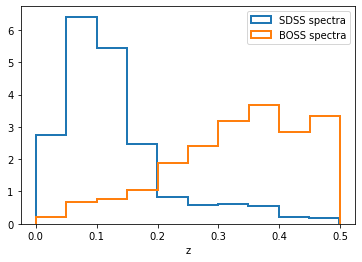

In [6]:
mask_skyline = True
intensity_limit = 2
radii = 5

mode = "test"
data_file = ["%s/sdssrand_N74000_spectra.npz"%(data_dir),
             "%s/bossrand_N74000_spectra.npz"%(data_dir)]
n_encoder = 2

sdss_data = load_data(data_file[0], which=mode,device=None)
ids_sdss = list(sdss_data['id'])
wave_sdss = sdss_data['wave']
spec_sdss = sdss_data['y']#.detach().numpy()
w_sdss = sdss_data['w']
z_sdss = sdss_data['z']
norm_sdss = sdss_data["norm"]


if mask_skyline:
    locmask = skylines_mask(torch.tensor(wave_sdss))
    maskmat = locmask.repeat(w_sdss.shape[0],1)
    w_sdss[maskmat]=1e-6
    

boss_data = load_data(data_file[1], which=mode,device=None)
ids_boss = list(boss_data['id'])

wave_boss = boss_data['wave']
spec_boss = boss_data['y']#.detach().numpy()
w_boss = boss_data['w']
z_boss = boss_data['z']
norm_boss = boss_data["norm"]

if mask_skyline:
    locmask = skylines_mask(torch.tensor(wave_boss),intensity_limit=intensity_limit,radii=radii)
    maskmat = locmask.repeat(w_boss.shape[0],1)
    w_boss[maskmat]=1e-6
    
wave_sdss = torch.tensor(wave_sdss, dtype=torch.float32)
wave_boss = torch.tensor(wave_boss, dtype=torch.float32)

joint_ids = find_intersection(ids_sdss,ids_boss)

wh_joint_sdss = [ids_sdss.index(i) for i in joint_ids]
wh_joint_boss = [ids_boss.index(i) for i in sdss2boss(joint_ids)]

names = ["SDSS spectra", "BOSS spectra"]
specs = [spec_sdss,spec_boss]
weights = [w_sdss, w_boss]
redshifts = [z_sdss, z_boss]
lognorms = [np.log10(norm_sdss), np.log10(norm_boss)]


for j in range(len(names)):
    plt.hist(redshifts[j].detach().numpy(),label=names[j], density=True,
             lw=2,histtype="step")
plt.legend(); plt.xlabel("z")

path: ./models/joint-v2.13.pt
states: dict_keys(['model', 'instrument', 'optimizer', 'scaler', 'scheduler', 'n_latent'])
model ./models/joint-v2.13: iterations 431, final loss: [0.47267479 0.50765343 0.41506695 0.46449024]


 ./models/joint-v2.13
0.47 is the minimum!


Text(0.5, 1.0, '($n_{latent}=2$) best loss = 0.51')

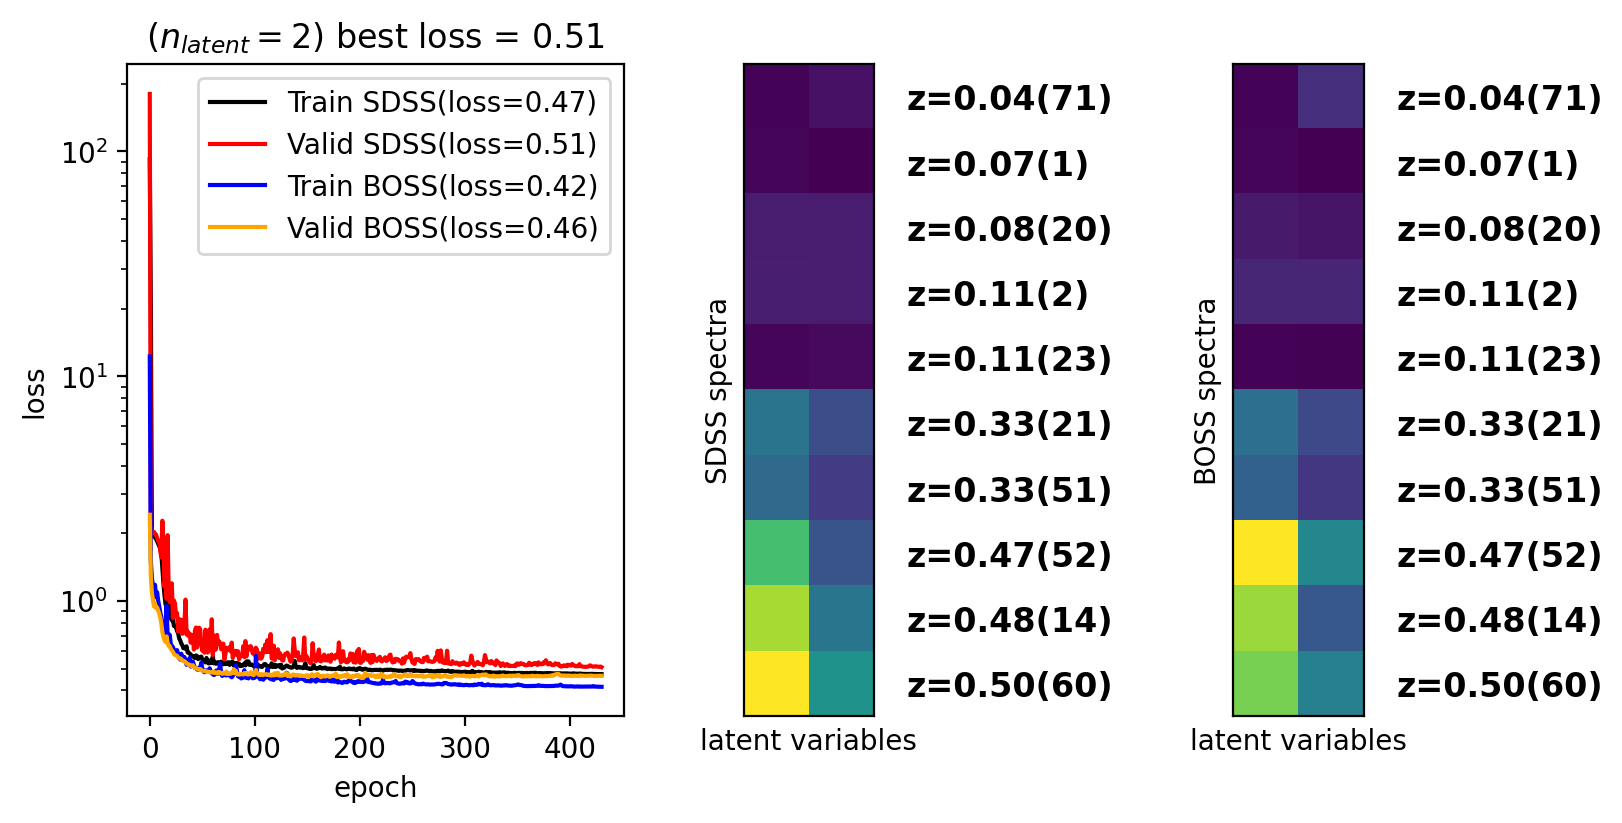

In [7]:
model_dir = "."
model_file = model_dir+"/models/joint-v2.13"
#model_file = model_dir+"/models/joint-v8.15"
#model_file = model_dir+"/models/robust-v8.9"
#model_file = model_dir+"/models/robust-v10.0"
#model_file = back_dir + "backup_model_401"

inspect_mix, loss = load_model("%s"%(model_file))

# for compatibility
inspect_mix[n_encoder].wave_obs = wave_sdss
inspect_mix[n_encoder+1].wave_obs = wave_boss
ins_sdss,ins_boss = inspect_mix[n_encoder:2*n_encoder]
instruments = [ins_sdss,ins_boss]

loss = loss.T
epoch = loss.shape[1]

# visualize 10 latent space
fig,axs = plt.subplots(1,3,figsize=(8,4),dpi=200, constrained_layout=True,
                       gridspec_kw={'width_ratios': [1.5, 1, 1]})

print("\n\n",model_file)
plot_loss(loss,ax=axs[0],fs=10)
np.random.seed(42) 
rand = np.random.randint(len(wh_joint_sdss), size=10)
#rand = np.arange(10)
for j in range(n_encoder):
    ax=axs[j+1]
    
    inds = np.array([wh_joint_sdss,wh_joint_boss][j])[rand]
    zlist = redshifts[j][inds].detach().numpy()
    rank = np.argsort(zlist)
    inds = inds[rank]
    #intersection = np.arange(len(inds))[rank]
    
    s, _, _ = inspect_mix[j]._forward(specs[j][inds], weights[j][inds],
                                      instruments[j],redshifts[j][inds])
    #s = normalize_s(s)
    s = s.detach().numpy()
    
    batch_size,s_size = s.shape
    locid = ["z=%.2f(%d)"%(n,ii) for ii,n in zip(rand[rank],redshifts[j][inds])] 

    vmin,vmax=s.min(),s.max()
    #print("vmin,vmax:",vmin,vmax)
    ax.matshow(s,vmax=vmax,vmin=vmin)#,cmap='winter')
    for i in range(len(locid)):
        ax.text(2,i+0.2,locid[i],c="k", weight='bold', fontsize=12,
                alpha=1)
    ax.set_xlabel("latent variables");ax.set_ylabel(names[j])
    ax.set_xticks([]);ax.set_yticks([])
    
#axs[0].set_ylim(0.5,1)
axs[0].set_title("($n_{latent}=%d$) best loss = %.2f"%(s_size,min(loss[1])))

In [104]:
#s

shape: (2, 98, 500)


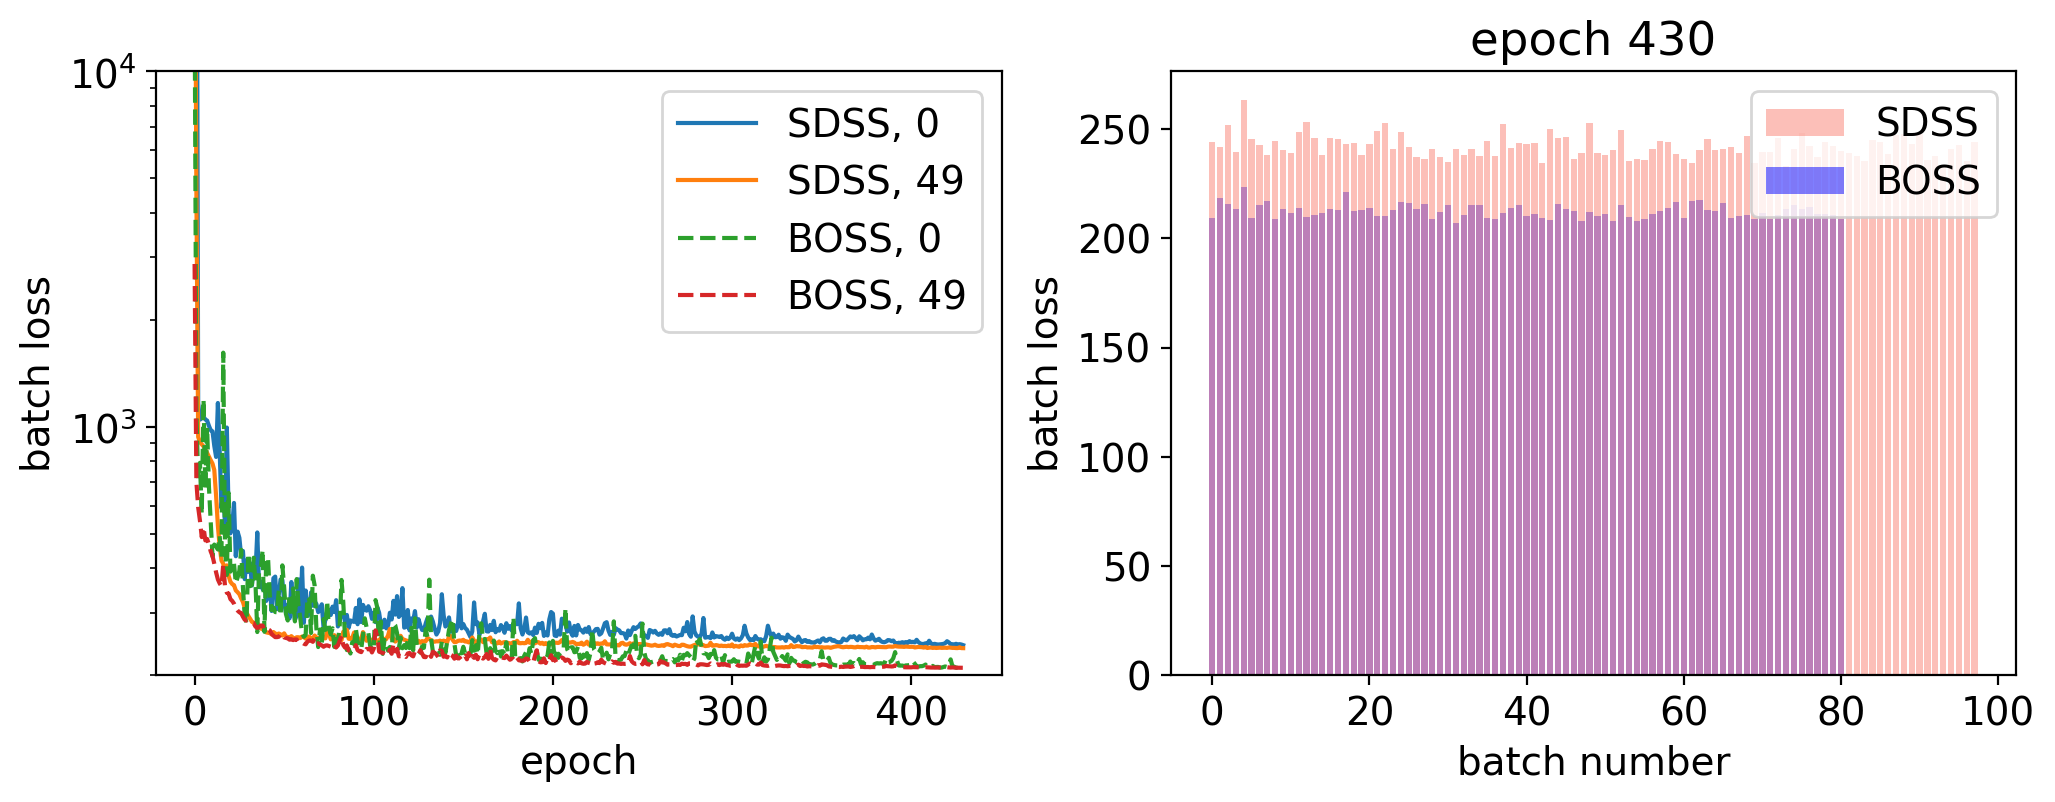

In [12]:
#"""
detail = np.load(f'{model_file}.detail.npy')
nbatch = detail.shape[1]
print("shape:",detail.shape)
bins = max(1,nbatch//2)
batch_size = 512


max_ind = max(np.nonzero(detail[0][0])[0])

inx = max_ind
state = [dd.T[inx] for dd in detail]

names = ["SDSS","BOSS"]
style = ["-",'--']
c = ['salmon','b']
fig,axs = plt.subplots(figsize=(12,4),ncols=2,dpi=200)
for j in range(len(names)):
    sample = detail[j][::bins].T
    labels = ["%s, %d"%(names[j],dd) for dd in range(nbatch)]
    labels = labels[::bins]
    ax = axs[0]
    for i in range(len(labels)):
        ax.semilogy(sample[:max_ind,i],style[j],label=labels[i])
        
    ax=axs[1]
    ax.bar(range(len(state[j])),state[j], alpha=0.5,fc=c[j],
           zorder=-j,fill=True,label=names[j])
    ax.set_title("epoch %d"%inx)
axs[0].set_ylim(200,1e4)
axs[0].set_xlabel("epoch");axs[0].set_ylabel("batch loss")
axs[0].legend(loc='best')
axs[1].set_xlabel("batch number");axs[1].set_ylabel("batch loss")
axs[1].legend(loc='best')

In [159]:
for p in inspect_mix[0].decoder.parameters():
    print("p",p[0])
    break

for p in inspect_mix[1].decoder.parameters():
    print("p",p[0])
    break
inspect_mix[1].decoder==inspect_mix[0].decoder

p tensor([ 0.1045, -0.2413], grad_fn=<SelectBackward0>)
p tensor([ 0.1045, -0.2413], grad_fn=<SelectBackward0>)


False

In [7]:
back_dir = "/home/yanliang/spectrum-encoder/backup/"
back_name = back_dir + "backup_model_%d"%epoch

torch.save(inspect_mix, '%s.pt'%back_name)
np.save('%s.losses.npy'%back_name, loss.T)

In [13]:
def plot_skylines(ax,ylim=(-1,10),xlim=(0,1),width=10,intensity_lim=5,
                  style="-",color='b',text=True,debug=False):
    f=open("sky-lines.txt","r")
    content = f.readlines()
    f.close()
    
    skylines = [[10*float(line.split()[0]),float(line.split()[1])] for line in content if not line[0]=="#" ]
    
    n_lines = 0
    
    for item in skylines:
        line, intensity = item
        if intensity<intensity_lim:continue
        if len(xlim)>0 and (line<xlim[0] or line>xlim[1]): continue
        n_lines += 1
        ax.axvline(line,ylim[0],ylim[1],ls=style,c=color)
        ax.axvspan(line-width,line+width,alpha=0.3,color=color)
        if text:ax.text(line,1.05*ylim[1],"%.1f"%line,rotation=90,c=color)
    
    if debug:print("number of lines: %d"%(n_lines))
    return

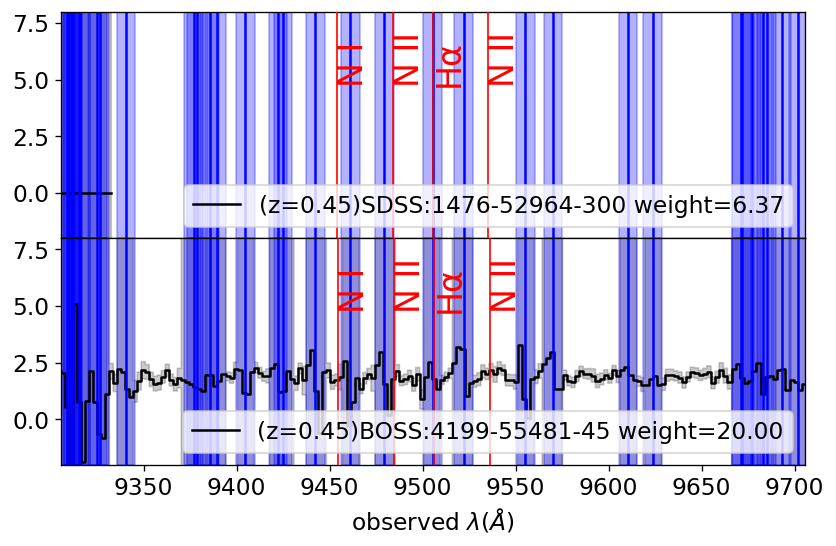

In [188]:
def inspect(where,text=False,xrange=100,wrest=6564.6, ylim=(-2,8)):
    colors = ['k']*10
    #wave_center = 8432.4910 # strong skyline in observed frame
    
    
    for number in where:


        which_sdss = [wh_joint_sdss[number]]
        which_boss = [wh_joint_boss[number]]
        #titles = ["SDSS:%s"%ids_sdss[wh_sdss[0]],
        #          "BOSS:%s"%ids_boss[wh_boss[0]]]
        titles = names
        which = [which_sdss,which_boss]
        true_z = [z_sdss[which[0]].item(),z_boss[which[1]].item()]

        ydata=[spec_sdss[which_sdss],spec_boss[which_boss]]
        instruments = inspect_mix[2:4]
        waves = [ins_sdss.wave_obs,ins_boss.wave_obs]
        weights = [w_sdss[which_sdss],w_boss[which_boss]]
        true_z = [z_sdss[which_sdss],z_boss[which_boss]]
        titles = ["SDSS:%s"%ids_sdss[which_sdss[0]],
                  "BOSS:%s"%ids_boss[which_boss[0]]]

        wave_center = wrest*(1+true_z[0])
        
        xlim = (wave_center-xrange,wave_center+xrange)

        fig,axs = plt.subplots(nrows=2,sharex=True,figsize=(8,5),dpi=120)
        fig.subplots_adjust(hspace=0)

        for j in range(2):
            ax=axs[j]
            disp_wave,disp_spec,disp_w = waves[j],ydata[j],weights[j]
            label = "(z=%.2f)%s weight=%.2f"%(true_z[j].item(),titles[j],weights[j].mean().item())

            yloc = disp_spec.detach().numpy()[0]
            y_err = (disp_w[0]**(-0.5)).numpy()
            y1 = yloc-y_err;y2 = yloc+y_err

            ax.fill_between(disp_wave,y1,y2,color=colors[j],step='mid',alpha=0.2,zorder=-10)
            ax.plot(disp_wave,yloc,c=colors[j],drawstyle='steps-mid',label=label)
            ax.legend(loc=4)


            #if j==1:text=False
            #else: text=True
            plot_skylines(ax,width=5,intensity_lim=2,debug=False,
                          xlim=xlim,ylim=ylim,color='b',text=text)

            add_emission(ax,z=true_z[j].item(),color="r",alpha=1,
                         xlim=xlim,ytext=5)
                         
            ax.set_xlim(xlim);ax.set_ylim(ylim)
            ax.set_xlabel("observed $\lambda (\AA)$")

inspect([24],xrange = 200)

In [189]:
skylines_mask(ins_sdss.wave_obs,intensity_limit=10,radii=5,debug=True)
skylines_mask(ins_boss.wave_obs,intensity_limit=10,radii=5,debug=True)

number of lines: 31, fraction: 0.04
number of lines: 95, fraction: 0.08


tensor([False, False, False,  ...,  True, False, False])

# Insert some random jittering...

In [14]:
def fake_jitter(params, which, offset=3, w_factor = [], flat_weight=[], locid=[], fix_z=False,
                model_free=[],plot=True,axs_list=None):
    colors = ['mediumseagreen',"skyblue",'salmon','orange','gold']
    code = ["SDSS","BOSS"]
    
    which_sdss,which_boss = which
    
    if which_boss==[]:
        ydata=[spec_sdss[which_sdss]]
        instruments = [inspect_mix[1]]
        waves = [ins_sdss.wave_obs]
        weights = [w_sdss[which_sdss]]
        true_z = [z_sdss[which_sdss]]
        titles = ["SDSS:%s"%ids_sdss[which_sdss[0]]]
    else:
        ydata=[spec_sdss[which_sdss],spec_boss[which_boss]]
        instruments = inspect_mix[2:4]
        waves = [ins_sdss.wave_obs,ins_boss.wave_obs]
        weights = [w_sdss[which_sdss],w_boss[which_boss]]
        true_z = [z_sdss[which_sdss],z_boss[which_boss]]
        titles = ["SDSS:%s"%ids_sdss[which_sdss[0]],
                  "BOSS:%s"%ids_boss[which_boss[0]]]
    
    n_test = len(params)
    print(n_test)
    
    if w_factor ==[]: w_factor = np.ones(n_test)
    if model_free ==[]: model_free = [True]*n_test
    if flat_weight ==[]: flat_weight = [False]*n_test
    
    ndata = len(ydata)
    embed = torch.zeros((ndata,n_test+1,s_size))
    flat_ydata = []
    mean_weights = []
    rest_models = []
    
    # two dataset
    for j in range(ndata):
        loss_total = 0
        #if ndata>1:ax = axs[j]
        axs=axs_list[j]
        ax = axs[0]
        
        recon = torch.zeros((n_test+1,len(instruments[j].wave_obs)))
        recon_w = torch.zeros((n_test+1,len(instruments[j].wave_obs)))
        

        for i,param in enumerate(params):
            z_new,n_jit = param
            wrest = inspect_mix[j].decoder.wave_rest
            wave_data = waves[j]/(1+true_z[j])
            
            zfactor = (1+z_new)/(1+true_z[j])
            locwave = waves[j][None,:]
            
            # define recon_ij
            if model_free[i]:
                # no artifitial redshift
                if fix_z:
                    recon_ij = torch.clone(ydata[j])
                    fake_w = torch.clone(weights[j])
                # apply artifitial redshift
                else:
                    # redshift linear interpolation
                    recon_ij = Interp1d()(locwave*zfactor,ydata[j],locwave)
            # model based spectra
            else:
                clean_model = inspect_mix[j].forward(ydata[j], weights[j], instruments[j],torch.tensor([z_new]).float())
                recon_ij = torch.clone(clean_model)
            
            # define fake_w
            if flat_weight[i]:
                
                fake_w =  weights[j].mean()*torch.ones_like(recon_ij)
                fake_w[weights[j]<2e-6] = 1e-6
            else: fake_w = Interp1d()(locwave*zfactor,weights[j],locwave)
            
            if locid != []:
                if locid[i]=="nothing + true w":
                    recon_ij = torch.ones_like(recon_ij)
                if "permute w" in locid[i]:
                    print("permuting weights! size =", fake_w.shape[1])
                    reorder = permute_indices(fake_w.shape[1])
                    fake_w[0] = fake_w[0][reorder]
                    fake_w[weights[j]<2e-6] = 1e-6

                    
            loc,amp = insert_jitters(recon_ij[0],n_jit)
            
            recon_ij[0][loc] += amp
            fake_w[0][loc] = 1/(amp**2+1/fake_w[0][loc])
            
            
            med = recon_ij.median(1,False).values[:,None]
            med[med<1e-1] = 1e-1
            #recon_ij /= med
            #med = recon_ij.median(1,False).values
            #print("median:",med)
            
            fake_w*=w_factor[i]
            print("z=%.2f weight: %.2f"%(z_new,fake_w.mean().item()))
            
            # model arguments
            args = (recon_ij.float()/med, fake_w.float(), instruments[j],
                    torch.tensor([z_new]).float())
            
            latent,y_rest,yobs = inspect_mix[j]._forward(*args)
            
            embed[j][i] = latent[0]
            recon[i] = recon_ij[0]
            recon_w[i] = fake_w[0]
            wave_z0 = (instruments[j].wave_obs.unsqueeze(1)/(1 + true_z[j])).T
            wave_rest = inspect_mix[j].decoder.wave_rest.repeat(1,1)
            
            # resample model on restframe data
            spec_new = Interp1d()(wave_rest,y_rest,wave_z0)
            wave_new = wave_z0[0]
            
            full_data, fw = ydata[j],weights[j]
            #full_data,fw = full_ij,full_w
            loss = inspect_mix[j]._loss(full_data, fw, spec_new)
            
            loss_total += loss
            if not plot:continue

            loc_off = offset*(i+1)
            
            yobs = yobs.detach()[0]+loc_off
            y_rest = y_rest[0].detach()+loc_off
            
            
            disp_wave,disp_ij,disp_w = waves[j]/(1+z_new),recon_ij,fake_w
            
            #print("disp_wave,disp_ij,disp_w:",disp_wave.shape,disp_ij.shape,disp_w.shape)
            yloc = disp_ij.detach().numpy()[0]+loc_off
            y_err = (disp_w[0]**(-0.5)).numpy()
            
            y_err[y_err>0.5*offset]=0.5*offset
            y1 = yloc-y_err;y2 = yloc+y_err

            if locid ==[]: label = "N=%d, z=%.2f (loss=%.2f)"%(n_jit,z_new,loss)
            else: label = "%s (loss=%.2f)"%(locid[i],loss)
                
            ax.fill_between(disp_wave,y1,y2,color=colors[i],alpha=0.5)
            ax.plot(disp_wave,yloc,c=colors[i],drawstyle='steps-mid',
                    label=label)
            
            #ax.plot(waves[j],yobs,c='k',lw=0.5)
            ax.plot(wrest,y_rest,drawstyle='steps-mid',
                    c='k',lw=0.5)
            
            #axs[1].plot(wrest,y_rest-loc_off,c='k',ls='-',alpha=0.7,lw=1.5)
            axs[1].plot(wave_new,spec_new.detach()[0],c=colors[i],
                        lw=3, zorder=0, drawstyle='steps-mid',label=label)
            
            axs[2].plot(wave_new,spec_new.detach()[0],c=colors[i],
                        lw=1, zorder=0, drawstyle='steps-mid',label=label)
            
            
        wj = weights[j]
        
        args = (ydata[j], wj, instruments[j], true_z[j])
        latent,y_rest,yobs = inspect_mix[j]._forward(*args)
        loss = inspect_mix[j].loss(*args)
        
        y_rest = y_rest[0].detach()
        
        embed[j][-1] = latent[0]
        recon[-1] = ydata[j][0]
        recon_w[-1] = wj[0]
        
        mean_loss = loss_total/len(params)
        print("%s mean weight: %.2f  mean loss: %.2f"%\
              (code[j],weights[j].mean().item(),mean_loss))
        
        mean_weights.append(weights[j].mean().item())
        
        #bad = weights[j][0]<1e-4
        if not plot:continue
        
        y_err=wj[0]**(-0.5)
        y_err[y_err>0.5*offset]=0.5*offset
        
        title = titles[j]
        print(title)
        
        
        flat_ydata.append(ydata[j].detach()[0])
        #ydata[j] = ydata[j].detach()[0]
        
        
        ax.fill_between(wave_data,flat_ydata[j]-y_err,flat_ydata[j]+y_err,color="k",alpha=0.2,zorder=-10)
        ax.plot(wave_data,flat_ydata[j],"k-")
        ax.plot(wrest,y_rest,drawstyle='steps-mid', c='r',
                label="true loss: %.2f"%loss,lw=0.5)
        
        ax.set_ylim(-1*offset,(n_test+1)*offset)
        #ax.legend(title=title,loc='best')
        ax.set_xlabel("restframe $\lambda (\AA)$")
        ax.set_title("(z=%.2f) %s"%(true_z[j],title))
        
        axs[1].set_title("(z=%.2f) %s"%(true_z[j],title))
        axs[1].fill_between(wave_data,flat_ydata[j]-y_err,flat_ydata[j]+y_err,
                            color="k",step='mid',alpha=0.2,zorder=-10)
        axs[1].plot(wave_data,flat_ydata[j],"k-",lw=2,
                    drawstyle='steps-mid')
        
        axs[1].plot(wrest,y_rest,"r-",lw=2,drawstyle='steps-mid',
                    label="true loss: %.2f"%loss)#,lw=0.5)
        axs[1].set_xlabel("restframe $\lambda (\AA)$")
        
        
        
        axs[2].set_title("(z=%.2f) %s"%(true_z[j],title))
        axs[2].fill_between(wave_data,flat_ydata[j]-y_err,flat_ydata[j]+y_err,
                            color="k",step='mid',alpha=0.2,zorder=-10)
        axs[2].plot(wave_data,flat_ydata[j],"k-",lw=1,zorder=-10,
                    drawstyle='steps-mid')
        
        axs[2].plot(wrest,y_rest,"r-",lw=1,drawstyle='steps-mid',
                    label="true loss: %.2f"%loss)#,lw=0.5)
        axs[2].set_xlabel("restframe $\lambda (\AA)$")

        # compare models
        rest_models.append(y_rest)
        
        xlim = (6530,6600)
        msk = (wave_data>xlim[0])*(wave_data<xlim[1])
        axs[1].set_xlim(xlim)
        if len(flat_ydata[j][msk])>0:axs[1].set_ylim(0.3,1.2*flat_ydata[j][msk].max().item())
        #print("y_rest[msk].max():",y_rest[msk].max())
        add_emission(axs[1],z=0, ymax=1.4*y_rest.max(),xlim=xlim)#, ymax=0)
        
        xlim = (wave_data.min(),wave_data.max())
        msk = (wrest>xlim[0])*(wrest<xlim[1])
        axs[2].set_xlim(xlim[0],xlim[1])
        axs[2].set_ylim(-0.5,min(2.5,1.2*y_rest[msk].max()))
        #axs[2].legend(title=title,loc='best')
        
        
        axs[2].legend(loc=4)
        #if plot:plt.tight_layout()
    
    cross_loss = []
    # evaluate SDSS vs BOSS loss
    # interpolate to SDSS
    wave_z0 = (instruments[0].wave_obs.unsqueeze(1)).T
    boss_model = Interp1d()(waves[1],ydata[1],wave_z0)
    S2B_data_ratio = ydata[0]/boss_model
    
    loss = inspect_mix[0]._loss(ydata[0], weights[0], boss_model)
    cross_loss.append(loss.item())
    print("wave_z0",wave_z0.shape, "boss_model",boss_model.shape, "boss loss:",loss)
    
    # interpolate to BOSS
    wave_msk = (waves[1]>waves[0].min())*(waves[1]<waves[0].max()).unsqueeze(0)
    wave_z0 = (waves[1][wave_msk[0]].unsqueeze(1)).T
    sdss_model = Interp1d()(waves[0],ydata[0],wave_z0)
    print("wave_msk:", wave_msk.shape,"ydata[1]:",ydata[1].shape,"weights[1]:",weights[1].shape)
    loss = inspect_mix[1]._loss(ydata[1][wave_msk].unsqueeze(0), weights[1][wave_msk].unsqueeze(0), sdss_model)
    print("wave_z0",wave_z0.shape, "sdss_model",sdss_model.shape, "sdss loss:",loss)
    cross_loss.append(loss.item())
    
    S2B_ratio = rest_models[0]/rest_models[1]
    print("S2B ratio:",S2B_ratio.shape,S2B_ratio)
    
    other = {"S2B":S2B_ratio,"S2B_data_ratio":S2B_data_ratio}
    return embed,mean_loss,cross_loss,mean_weights,other

def plot_latent(embed, true_z, axs, titles=[], locid=[]):
    if titles==[]:titles=[""]*n_encoder
    if locid==[]:locid = ["z=%.2f"%n for n in newz] + ["true z=%.2f"%true_z[j]]
    # plot latent variables
    for j in range(n_encoder):
        ax = axs[j]
        s = embed[j].detach().numpy()
        # visualize latent space
        ax.matshow(s,vmax=vmax,vmin=vmin)#,cmap='winter')
        
        title="%s"%(titles[j])
        
        for i in range(len(locid)):
            ax.text(1.7,i+0.2,locid[i],c="k", weight='bold',fontsize=25)
        ax.set_xlabel("latent variables");ax.set_ylabel("copies")
        ax.set_title(title,weight='bold',fontsize=30)
        ax.set_xticks([]);ax.set_yticks([])
    return

In [15]:
import umap
from scipy import signal

#interesting = [14019,4207,4839,121,6776]

N = 1000
rand1 = np.random.randint(len(ids_sdss), size=N)
#wh_boss=np.random.randint(len(ids_boss), size=N)
rand2 = np.random.randint(len(ids_boss), size=N)

#ids_sdss[rand1]
s_sdss, _, _ = inspect_mix[0]._forward(spec_sdss[rand1], w_sdss[rand1], ins_sdss,z_sdss[rand1])
#sdss_model = sdss_random.detach().numpy()
s_boss, _, _ = inspect_mix[1]._forward(spec_boss[rand2], w_boss[rand2], ins_boss,z_boss[rand2])
#s_boss, _, _ = inspect_mix[1]._forward(spec_boss[wh_boss], w_boss[wh_boss], ins_boss,z_boss[wh_boss])
#boss_model = boss_random.detach().numpy()
print("[Random sample] SDSS:",s_sdss.shape)#,"BOSS:",s_boss.shape)

[Random sample] SDSS: torch.Size([1000, 2])


In [16]:
number = 7#[1,6,7,12,24,41]
wh_sdss = [wh_joint_sdss[number]]
wh_boss = [wh_joint_boss[number]]
#titles = ["SDSS:%s"%ids_sdss[wh_sdss[0]],
#          "BOSS:%s"%ids_boss[wh_boss[0]]]
titles = names
which = [wh_sdss,wh_boss]
true_z = [z_sdss[which[0]].item(),z_boss[which[1]].item()]


nparam = 4

w_factor = [];use_data=[];flat_weight=[];number = np.zeros(nparam);
#newz = np.array([0.45]*nparam)
newz = np.linspace(0,0.5,4)#[0.0,0.1,0.2,0.4]

newz[newz<0]=0
newz[newz>0.5]=0.5
print(newz)

#number = np.array([0, 1000, 1500,3000])
#w_factor = [0.1,1,10,100,500]
#locid = ["w*=%s"%str(n) for n in w_factor]

locid = ["z=%.2f"%n for n in newz]
#locid = ["N=%d"%n for n in number]
#locid = ["data + true w","data + flat w","nothing + true w", "data + permute w"]
#locid = ["data + flat w","model + flat w",
#         "data + true w","model + true w"]

#use_data = ["data" in item for item in locid]
#flat_weight = ["flat" in item for item in locid]

locid += ["raw data"]
#number = np.random.randint(100,500, size=len(newz))#[0,500,1000]#
params = np.array([newz,number]).T

[0.         0.16666667 0.33333333 0.5       ]


4
z=0.00 weight: 147.05
z=0.17 weight: 154.33
z=0.33 weight: 137.49
z=0.50 weight: 111.76
SDSS mean weight: 154.87  mean loss: 0.54
SDSS:405-51816-177
z=0.00 weight: 465.26
z=0.17 weight: 477.47
z=0.33 weight: 424.33
z=0.50 weight: 354.18
BOSS mean weight: 477.85  mean loss: 0.84
BOSS:4235-55451-16
wave_z0 torch.Size([1, 3921]) boss_model torch.Size([1, 3921]) boss loss: tensor(0.5759)
wave_msk: torch.Size([1, 4665]) ydata[1]: torch.Size([1, 4665]) weights[1]: torch.Size([1, 4665])
wave_z0 torch.Size([1, 3919]) sdss_model torch.Size([1, 3919]) sdss loss: tensor(9.5779)
S2B ratio: torch.Size([7000]) tensor([0.9966, 0.9942, 0.9832,  ..., 1.0418, 1.2281, 0.7010])
[1000, 1000, 1, 5, 5]


Text(0.1, 8.0, 'Data similarity:\nSDSS/BOSS as model: 9.58 vs. 0.58\nSDSS/BOSS weight: 154.87 vs. 477.85')

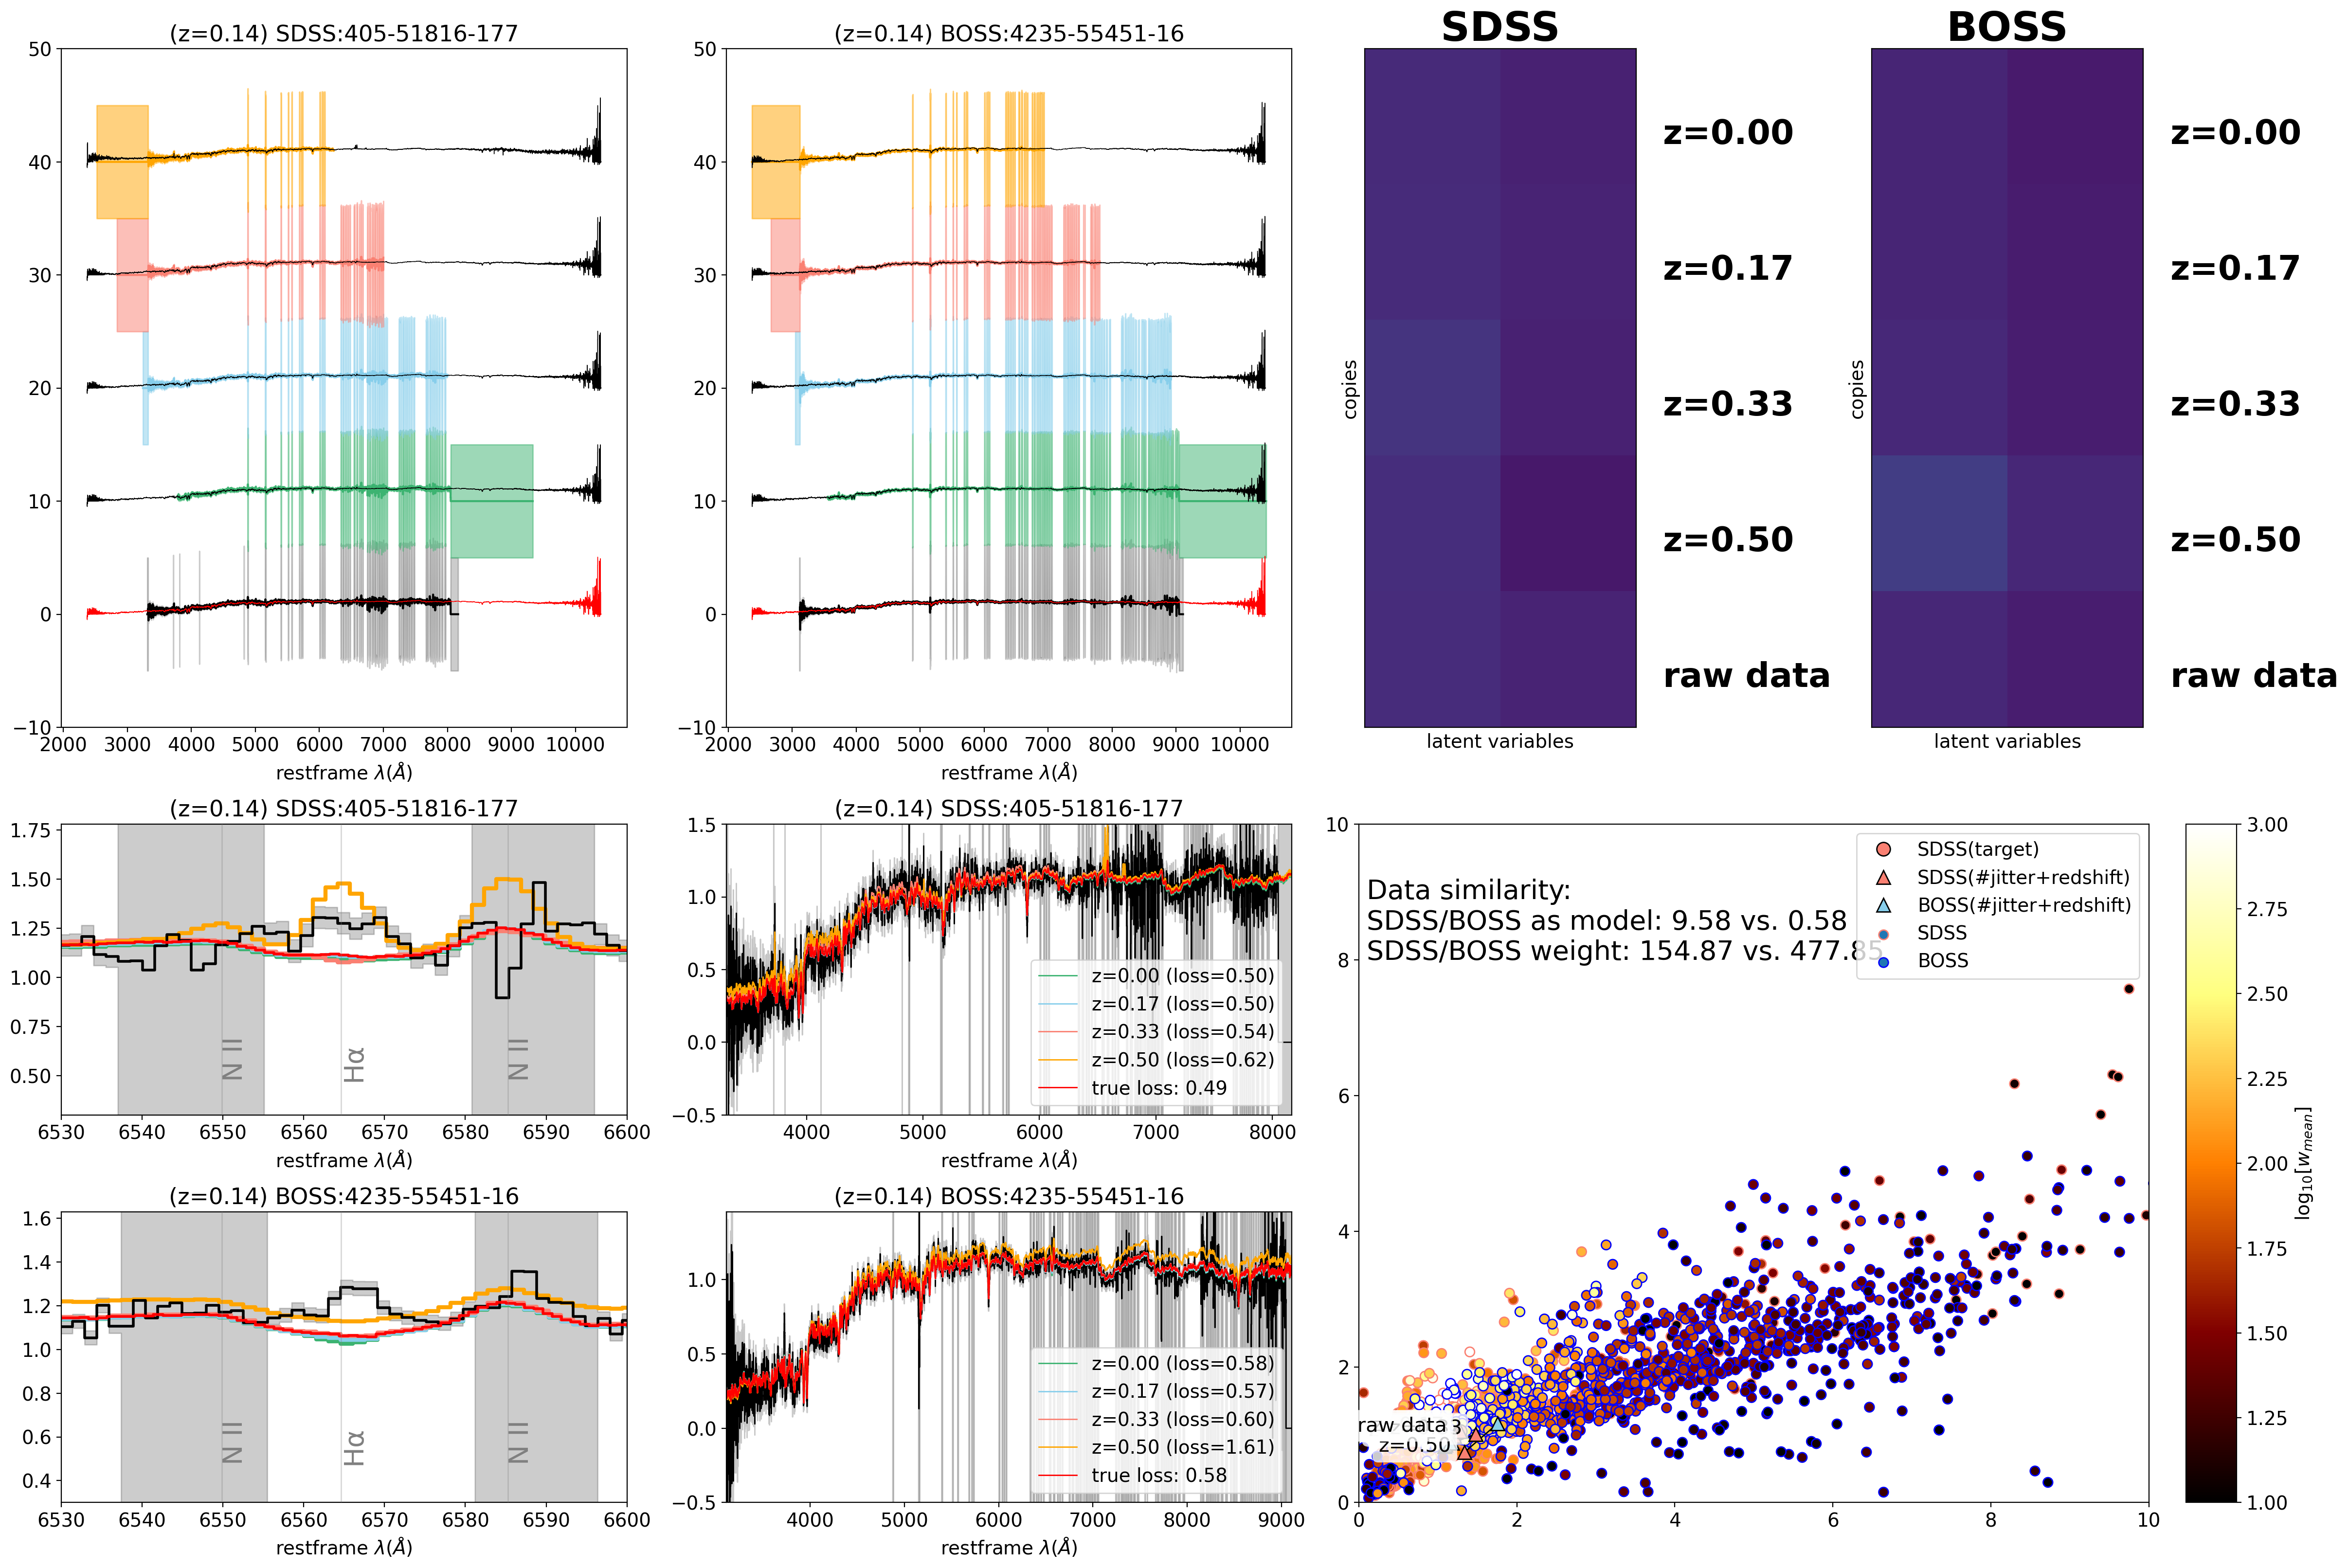

In [17]:
show_s = True

#fig,axs = plt.subplots(ncols=ndata,nrows=3)
fig = plt.figure(constrained_layout=True,figsize=(24,16),dpi=200)
gs = fig.add_gridspec(4, 4, width_ratios=[1,1,0.5,0.5],hspace=0.01)
ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[:2, 1])

ax3 = fig.add_subplot(gs[:2, 2])
ax4 = fig.add_subplot(gs[:2, 3])

ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[3, 0])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[3, 1])

ax9 = fig.add_subplot(gs[2:4,2:4])
sdss_axs = [ax1,ax5,ax7]
boss_axs = [ax2,ax6,ax8]
axs = [sdss_axs,boss_axs]

embed,mean_loss,cross_loss,mean_weights,other = \
fake_jitter(params,which, model_free=use_data, flat_weight=flat_weight,locid=locid,
            w_factor=w_factor,fix_z=False,offset=10,axs_list=[sdss_axs,boss_axs])

test_embed = [item for item in embed]#,jitter[1]]
sdss_track,boss_track = embed[0][-1][None],embed[1][-1][None]

#"""
basic = [s_sdss,s_boss,sdss_track]
s_mat, keys = concatenate(basic+test_embed,dim=s_size)
s_mat = s_mat.detach().numpy()

# 2D!!
if show_s and s_mat.shape[1]: embedding = s_mat
else: 
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(s_mat)

embedded = [embedding[key].T for key in keys]
embedded_batch = [embedded[:2],embedded[2:3],embedded[3:]]

#"""
plot_latent(embed,true_z,[ax3,ax4],titles=titles,locid=locid)
#"""
colors = [['salmon','skyblue'],['salmon','skyblue'],['orange',"navy"],['gold','azure']]
name = ["target","#jitter+redshift"]

#embed_color=[z_sdss[rand1],z_boss[rand2]]
mean_logweights = [torch.log10(torch.mean(weights[j],dim=1)) for j in range(n_encoder)]
embed_color=[mean_logweights[0][rand1],mean_logweights[1][rand2]]
cbar_label = "$\log_{10}[w_{mean}]$"


mark_id = np.array(ids_sdss)[wh_sdss]

comment = [{"ID":mark_id,"wh":1},
           {"pos":(-10,0),"ID":locid+[None],"wh":0}]
plot_embedding(embedded_batch,embed_color,name=name,comment=comment,
               cbar_label=cbar_label, c_range=[1,3],
               markers=["o","^","s"],color=colors, ax=ax9, mute=True,
               zoom=False, cmap="afmhot")

xlim = (0,10);ylim = (0,10)
ax9.set_xlim(xlim);ax9.set_ylim(ylim)

text = "Data similarity:\nSDSS/BOSS as model: %.2f vs. %.2f\n"%(cross_loss[1],cross_loss[0])
text += "SDSS/BOSS weight: %.2f vs. %.2f"%(mean_weights[0],mean_weights[1])
ax9.text(0.1,0.8*ylim[1],text,fontsize=20)
#plt.savefig("[%d][loss=%.2f]z=%.2f.png"%(wh_sdss[0],mean_loss,true_z[0]),dpi=200)

(0.5, 1.5)

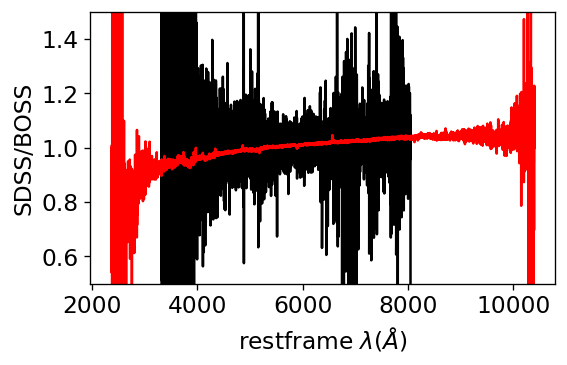

In [19]:
wrest = inspect_mix[0].decoder.wave_rest;msk = (wrest>3000)*(wrest<7500)
fig,ax = plt.subplots(figsize=(5,3),dpi=120)
ax.plot(wave_sdss/(1+true_z[0]),other['S2B_data_ratio'][0],"k-")
ax.plot(wrest,other['S2B'],"r-")
ax.set_xlabel("restframe $\lambda (\AA)$")
ax.set_ylabel("SDSS/BOSS")
xlim = (6530,6600)
#ax.set_xlim(xlim)
ax.set_ylim(0.5,1.5)

In [184]:
#import pickle

#header_name = "boss_headers.pkl"
#save_dir = "/home/yanliang/spectrum-encoder/%s"%header_name

#f = open(save_dir,"rb")
#targets = pickle.load(f)
#f.close()

tensor([ 2371.0000,  2372.1475,  2373.2949,  ..., 10399.7051, 10400.8525,
        10402.0000])